# Hands-on Deep Generative Models

**Authors:** M. Barbetti (INFN-CNAF), S. Capelli (INFN-MiB), F. Vaselli (INFN-Pisa)

**Date created:** 30/10/2023

**Last modified:** 30/10/2023

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/mlinfn-advanced-hackathon/tutorial_gen_models.ipynb)
[![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/mbarbetti/mlinfn-advanced-hackathon/tutorial_gen_models.ipynb)
[![Open in GitHub](https://img.shields.io/badge/Open_in_GitHub-blue?style=flat&logo=github&logoColor=white&labelColor=555)](https://github.com/mbarbetti/mlinfn-advanced-hackathon/tutorial_gen_models.ipynb)

**Description:** This hands-on demonstrates how deep generative models succeed in reproducing the high-level response of a generic HEP experiment, offering a viable solution to reduce the pressure on the computing budget for simulation production. In particular, in this notebook we will test the performance of Generative Adversarial Networks and Normalizing Flows to parameterize the errors introduced during the detection and reconstruction of high-energy particle jets using the CMS detector.

## Introduction

### What is CMS?

TBA

#### Measuring jets at CMS

TBA

### What are Deep Generative Models?

#### Generative Adversarial Networks

Generative Adversarial Networks [[1](https://arxiv.org/abs/1406.2661)] are a powerful class of _generative models_ based on the simultaneous training of two neural networks:

*  **Discriminator network** ($D$) - trained by a classification task to separate the generator output from the reference dataset
* **Generator network** ($G$) - trained by a simulation task to reproduce the reference dataset trying to fake the discriminator

The goal is that $D$ optimally discriminates on the origin of the two samples, and simultaneously the training procedure for $G$ is to maximize the _probability_ of $D$ making a mistake. This framework corresponds to a **minimax two-player game** [[1](https://arxiv.org/abs/1406.2661)].

Traditional GAN systems suffer from many issues, particularly during the training phase:

* the generator may _collapse_ producing only a single sample or a small family of very similar samples (**mode collapse**)
* the two players may _oscillate_ during training rather than converging to the [**Nash equilibrium**](https://en.wikipedia.org/wiki/Nash_equilibrium)
* if _imbalance_ between the two players occurs, then the system is incapable of learning at all

All these drawbacks result from the [**vanishing gradient problem**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), namely the lack of information for the update of the $G$ parameters. This is due to the saturation of the $D$ that is so good in distinguishing the origin of the two samples that no errors remain to the $G$ to improve the generated space [[2](https://arxiv.org/abs/1701.04862)]. To fix the problem, ... [TBA]

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/gan-scheme.png" width="800"/>
</div>

#### Normalizing Flows

TBA

## Hands-on generative models with CMS data

TBA

### Prerequisites

The first step is to install the [pidgan](https://github.com/mbarbetti/pidgan) package and some other ones that are typically needed in machine learning applications to High Energy Physics (i.e., uproot, scipy, scikit-learn, matplotlib).

```
%%capture
!pip install pidgan[hep]
```

Now, let's verify the correct installation of pidgan printing its version:

In [1]:
import pidgan

pidgan.__version__

'0.0.6'

In case you're running this notebook on a machine equipped with a GPU, let's also verify the correct installation of TensorFlow:

In [2]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")  # outputs a non-empty list in case of GPU equipped

2023-10-30 23:15:14.385058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 23:15:15.179069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]

Finally, we just have to import all the modules that we will use in the following code cells:

In [3]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, StandardScaler, LabelEncoder, OneHotEncoder

### Data loading

The data needed for this tutorial is provided through a CSV file downloadable from the [pidgan-notebooks](https://github.com/mbarbetti/pidgan-notebooks) repository.

**Disclaimer:** The data results from a toy model inspired to the LHCb RICH system combining its high-level response when traversed by a set of long-lived charged particles, namely muons, pions, kaons and protons.

The CSV file contains 250000 instances, 4 input features and 4 output features. Let's import the data as a pandas [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html):

In [4]:
with uproot.open("./data/cms_data.root") as file:
  data = file["recojet"].arrays(library="pd").drop("index", axis=1)

data.describe()

,pT,theta,phi,E,b_tag,flavour,reco_pT,reco_theta,reco_phi,reco_nConstituents
count,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06
mean,5.774316e+01,-3.606635e-03,3.142674e+00,1.820326e+02,3.891182e-01,-1.751057e-03,5.823546e+01,-3.583049e-03,3.142717e+00,1.772764e+01
std,4.740463e+01,1.698428e+00,1.813134e+00,2.612149e+02,3.799157e-01,2.957189e+00,4.954559e+01,1.698818e+00,1.813508e+00,8.978564e+00
min,1.500001e+01,-6.247127e+00,1.370349e-06,1.511571e+01,3.145769e-05,-5.000000e+00,-2.736475e+00,-6.225502e+00,1.377906e-06,0.000000e+00
25%,2.606500e+01,-1.156958e+00,1.575168e+00,5.171500e+01,5.980294e-02,0.000000e+00,2.604108e+01,-1.156651e+00,1.574912e+00,1.100000e+01
50%,4.404862e+01,-4.191196e-03,3.141528e+00,9.736305e+01,1.744231e-01,0.000000e+00,4.390334e+01,-4.189691e-03,3.141232e+00,1.600000e+01
75%,7.374522e+01,1.150521e+00,4.711539e+00,1.969485e+02,8.527536e-01,0.000000e+00,7.428231e+01,1.150217e+00,4.712032e+00,2.300000e+01
max,1.568434e+03,6.298655e+00,6.283185e+00,5.069652e+03,9.999949e-01,5.000000e+00,1.915857e+03,6.525997e+00,6.533353e+00,1.100000e+02


Gen-level info:
* `data.pT` - transverse momentum in GeV/$c$ of the jet
* `data.theta` - angle of the jet direction in the z-y plane
* `data.phi` - angle of the jet direction in the x-y plane
* `data.E` - total energy in GeV of the jet
* `data.b_tag` - TBA
* `data.flavour` - TBA

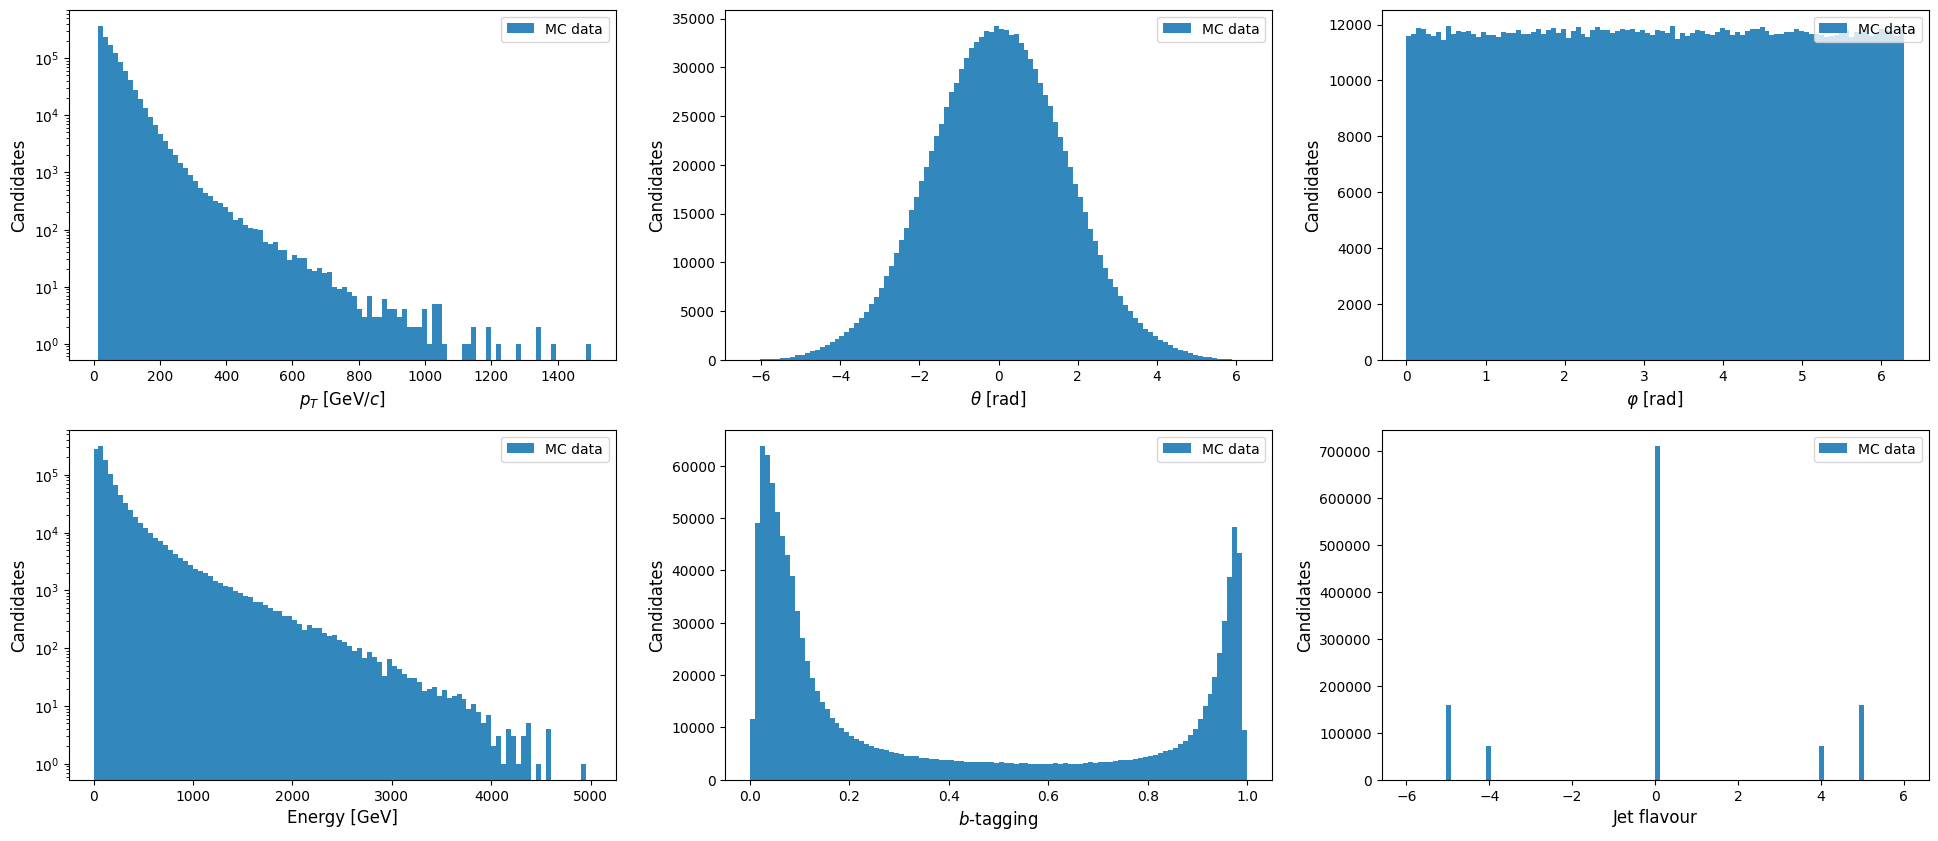

In [5]:
plt.figure(figsize=(24, 10))

plt.subplot(2, 3, 1)
plt.xlabel("$p_T$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["pT"], bins=np.linspace(0.0, 1500.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 3, 2)
plt.xlabel(r"$\theta$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["theta"], bins=np.linspace(-2*np.pi, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 3)
plt.xlabel(r"$\varphi$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["phi"], bins=np.linspace(0.0, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 4)
plt.xlabel("Energy [GeV]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["E"], bins=np.linspace(0.0, 5000.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 3, 5)
plt.xlabel("$b$-tagging", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["b_tag"], bins=np.linspace(0.0, 1.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 6)
plt.xlabel("Jet flavour", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["flavour"], bins=np.linspace(-6.0, 6.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.show()

Reco-level info:
* `data.reco_pT` - reconstructed transverse momentum in GeV/$c$ of the jet
* `data.reco_theta` - reconstructed angle of the jet direction in the z-y plane
* `data.reco_phi` - reconstructed angle of the jet direction in the x-y plane
* `data.reco_nConstituents` - TBA

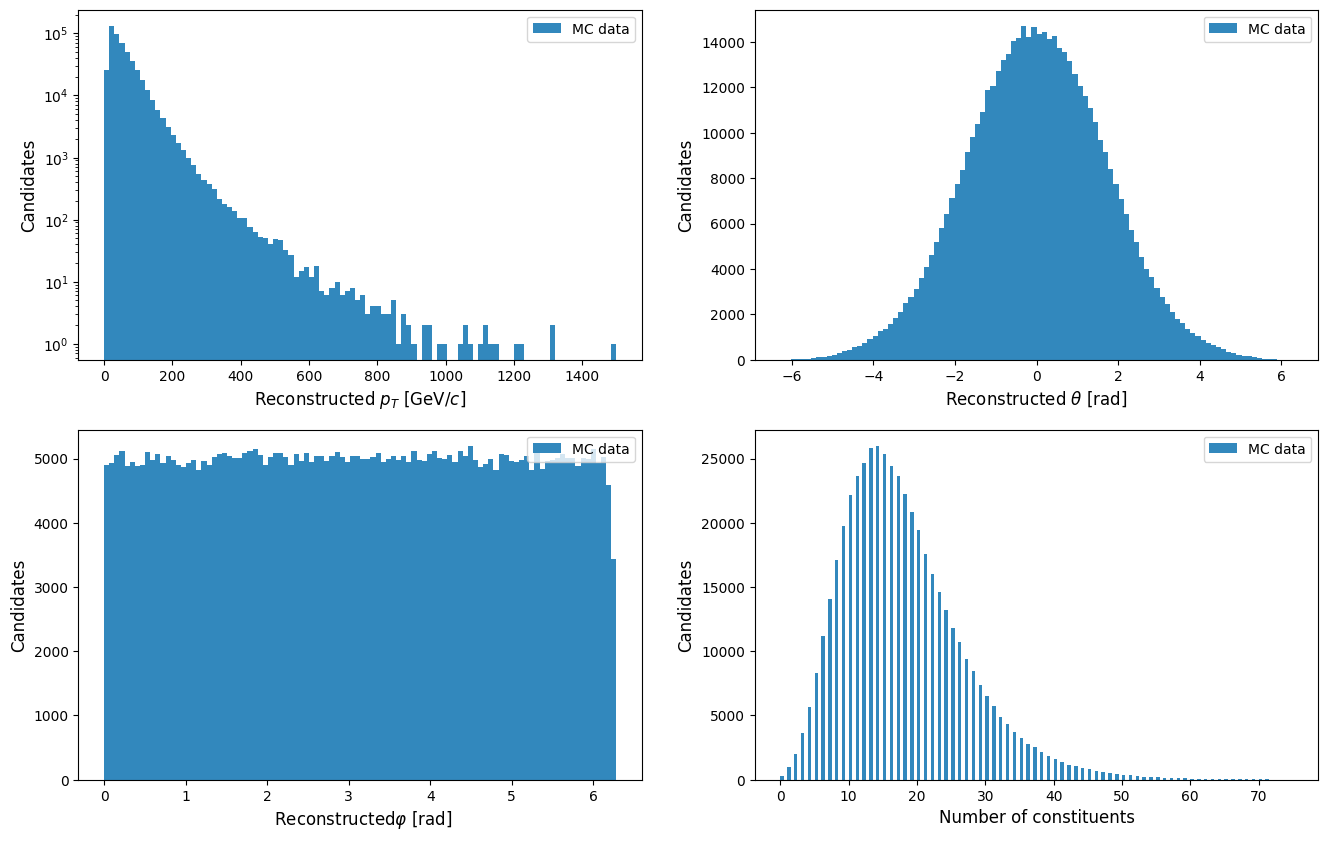

In [45]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.xlabel("Reconstructed $p_T$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_pT"], bins=np.linspace(0.0, 1500.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 2, 2)
plt.xlabel(r"Reconstructed $\theta$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_theta"], bins=np.linspace(-2*np.pi, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 2, 3)
plt.xlabel(r" Reconstructed$\varphi$ [rad]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_phi"], bins=np.linspace(0.0, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 2, 4)
plt.xlabel("Number of constituents", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_nConstituents"], bins=np.linspace(0.0, 75.0, 151), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.show()

### Data preprocessing

As usual in a machine learning application, the data sample is split into **training** and **test set**.

In [53]:
data = shuffle(data)

chunk_size = 500000  # -1 for the whole dataset
data = data[:chunk_size]

x_vars = ["pT", "theta", "phi", "E", "b_tag", "flavour"]
x = data[x_vars].values

y_vars = ["reco_pT", "reco_theta", "reco_phi", "reco_nConstituents"]
y = data[y_vars].values

train_ratio = 0.7
train_size = int(train_ratio * len(data))

x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"x_train shape: {x_train.shape} \t x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape} \t y_test shape: {y_test.shape}")

x_train shape: (350000, 6) 	 x_test shape: (150000, 6)
y_train shape: (350000, 4) 	 y_test shape: (150000, 4)


To normalize the different ranges and orders of magnitude of input $x$ and output $y$ features highlighted by the previous histograms, we will use the scikit-learn [`QuantileTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) using a Gaussian as output distribution.

Since one of the $x$ features is boolean (`data.flavour`), the latter should be kept unchanged. Let's preprocess the rest of the conditional information and verify the results with the [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) `describe()` method:

In [54]:
# x_scaler = ColumnTransformer(
#   [
#     ("quantile", QuantileTransformer(output_distribution="normal"), (0, 3, 4)),  # pT, E, b_tag
#     ("standard", StandardScaler(), (1, 2)),  # theta, phi
#   ]
# )
# x_train_prep = x_scaler.fit_transform(x_train[:, :5])
# 
# pd.DataFrame(x_train_prep, columns=["pT", "E", "b_tag", "theta", "phi"]).describe()

In [55]:
x_scaler = QuantileTransformer(output_distribution="normal")
x_train_prep = x_scaler.fit_transform(x_train[:, :-1])

pd.DataFrame(x_train_prep, columns=x_vars[:-1]).describe()

,pT,theta,phi,E,b_tag
count,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000
mean,-0.003156,0.012516,0.002276,0.015154,-0.025363
std,1.008481,1.003503,1.020391,1.003774,1.008325
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.680416,-0.652017,-0.689458,-0.659109,-0.690366
50%,0.001872,0.017428,-0.006536,0.018802,-0.023747
75%,0.670335,0.692126,0.698868,0.690495,0.650631
max,5.199338,5.199338,5.199338,5.199338,5.199338


In [56]:
label_encoder = LabelEncoder()
int_encoded = label_encoder.fit_transform(x_train[:, 5])

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(int_encoded[:, None])

x_train_prep = np.concatenate([x_train_prep, onehot_encoded], axis=1)
x_train_prep.shape

(350000, 10)

Let's preprocess also the $y$ features checking what obtained:

In [57]:
# y_scaler = ColumnTransformer(
#   [
#     ("quantile", QuantileTransformer(output_distribution="normal"), (0,)),  # reco_pT
#     ("standard", StandardScaler(), (1, 2, 3)),  # reco_theta, reco_phi, reco_nConstituents
#   ]
# )
# y_train_prep = y_scaler.fit_transform(y_train)
# 
# pd.DataFrame(y_train_prep, columns=y_vars).describe()

In [60]:
y_train[:, -1] += np.random.normal(0.0, 0.2, size=(len(y_train),))

y_scaler = QuantileTransformer(output_distribution="normal")
y_train_prep = y_scaler.fit_transform(y_train)

pd.DataFrame(y_train_prep, columns=y_vars).describe()

,reco_pT,reco_theta,reco_phi,reco_nConstituents
count,350000.000000,350000.000000,350000.000000,350000.000000
mean,0.009979,0.022240,-0.001945,-0.000412
std,1.008193,0.996610,1.011243,0.999878
min,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.673535,-0.640238,-0.686658,-0.674749
50%,-0.000775,0.037260,0.000258,0.002036
75%,0.681906,0.684047,0.682027,0.665919
max,5.199338,5.199338,5.199338,5.199338


### Generative Adversarial Networks

We are finally ready to define the **WGAN-ALP model** to be used to parameterize the RICH response. GAN algorithms rely on the competition (namely the minimax game) between the generator and discriminator networks. The latters are provided by the [pidgan](https://github.com/mbarbetti/pidgan) package through the [`players`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/players) module that implements the two networks customizing the TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class.

#### The generator

The **generator player** can be implemented with the high-level [`Generator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/generators/Generator.py) class that provides the neural network model wrapping the TensorFlow [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). Before to initialize a `Generator` instance, let's have a look at its arguments:

* **`output_dim`** (_int_) - Dimensionality of the generator output space.
* **`latent_dim`** (_int_) - Dimensionality of the latent space.
* **`num_hidden_layers`** (_int_, default=5) - Number of the hidden layers passed to the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model. Each hidden layer has a LeakyReLU as activation function (see [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU)).
* **`mlp_hidden_units`** (_int_ or _array_like_, default=128) - Number of neuron units per each hidden layer. It can also be passed as an array of unit numbers having length equal to the number of hidden layers.
* **`mlp_dropout_rates`** (_float_ or _array_like_, default=0.0) - Fraction of the input neurons to drop per each hidden layer. It can also be passed as an array of float numbers having length equal to the number of hidden layers.
* **`output_activation`** (_activation_like_ or _None_, default=None) - Activation function to use in the generator output layer (see [`tf.keras.activations`](https://www.tensorflow.org/api_docs/python/tf/keras/activations)). If None, no activation is applied (i.e., "linear" activation: $a(x) = x$).
* **`name`** (_str_ of _None_, default=None) - The name of the generator model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the generator layer computations and weights.

In [63]:
from pidgan.players.generators import Generator

generator = Generator(
    output_dim=y_train_prep.shape[-1],
    latent_dim=64,
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation=None,
    name="generator"
)

In [64]:
_ = generator(keras.Input(shape=x_train_prep.shape[1:]))
generator.summary()

Model: "generator_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 128)               9600      
                                                                 
 leaky_relu_0 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_0 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)             

#### The discriminator

The **discriminator player** can be implemented with the high-level [`Discriminator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/discriminators/Discriminator.py) class that provides the neural network model wrapping the TensorFlow [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). Again, before to initialize a `Discriminator` instance, let's have a look to its arguments:

* **`output_dim`** (_int_) - Dimensionality of the discriminator output space.
* **`num_hidden_layers`** (_int_, default=5) - Number of the hidden layers passed to the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model. Each hidden layer has a LeakyReLU as activation function (see [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU)).
* **`mlp_hidden_units`** (_int_ or _array_like_, default=128) - Number of neuron units per each hidden layer. It can also be passed as an array of unit numbers having length equal to the number of hidden layers.
* **`mlp_dropout_rates`** (_float_ or _array_like_, default=0.0) - Fraction of the input neurons to drop per each hidden layer. It can also be passed as an array of float numbers having length equal to the number of hidden layers.
* **`output_activation`** (_activation_like_ or _None_, default="sigmoid") - Activation function to use in the dicriminator output layer (see [`tf.keras.activations`](https://www.tensorflow.org/api_docs/python/tf/keras/activations)). If None, no activation is applied (i.e., "linear" activation: $a(x) = x$).
* **`name`** (_str_ of _None_, default=None) - The name of the discriminator model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the discriminator layer computations and weights.

In [65]:
from pidgan.players.discriminators import Discriminator

discriminator = Discriminator(
    output_dim=1,
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation=None,
    name="discriminator"
)

In [66]:
_ = discriminator((keras.Input(shape=x_train_prep.shape[1:]), keras.Input(shape=y_train_prep.shape[1:])))
discriminator.summary()

Model: "discriminator_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 128)               1920      
                                                                 
 leaky_relu_0 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_0 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)         

                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 leaky_relu_3 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 leaky_relu_4 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_out

#### The WGAN-ALP algorithm

The **WGAN-ALP algorithm** [[3](https://arxiv.org/abs/1701.07875)] can be implemented with the high-level [`WGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_ALP.py) class that defines the training procedure of the two players customizing the TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class and, in particular, its `fit()` method. Once again, before to initialize a `WGAN_ALP` instance, let's have a look at its arguments:

* **`generator`** (_generator_like_) - The generator network. It must be passed as a pidgan [`Generator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/generators/Generator.py) instance.
* **`discriminator`** (_discriminator_like_) - The discriminator network. It must be passed as a pidgan [`Discriminator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/discriminators/Discriminator.py) instance.
* **`lipschitz_penalty`** (_float_, default=1.0) - Importance of the regularization term ALP that explicitly constrains the discriminator to induce a 1-Lipschitz function as proposed in Ref. [[4](https://arxiv.org/abs/1907.05681)].
* **`lipschitz_penalty_strategy`** (_str_, default="one-sided") - If "two-sided" is passed, the Lipschitz constant computed along the virtual adversarial direction is forced to be equal to 1. When "one-sided" is preferred, only Lipschitz constant values greater than 1 are penalized.
* **`feature_matching_penalty`** (_float_, default=0.0) - Importance of the regularization term added to the generator training to force the hidden state of the discriminator to match between reference and generated examples. Its design follows from what proposed in Ref. [[8](https://arxiv.org/abs/1606.03498)].
* **`referee`** (_classifier_like_ or _None_, default=None) - When passed it enables the training of a third independent player: the referee network. It can be used to assess the quality of the generator output during the training. If passed, it must be a pidgan [`Classifier`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/classifiers/Classifier.py) instance.
* **`name`** (_str_ or _None_, default=None) - The name of the WGAN-ALP model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the WGAN-ALP model computations.

To not further complicate this tutorial, we avoid to use the referee network in this case, even if its initialization is straightforward:

```python
from pidgan.players.classifiers import Classifier

referee = Classifier(
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    name="referee"
)
```

It's time to initialize a [`WGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_ALP.py) instance!

In [67]:
from pidgan.algorithms import BceGAN_ALP

gan = BceGAN_ALP(
    generator=generator,
    discriminator=discriminator,
    lipschitz_penalty=1.0,
    lipschitz_penalty_strategy="one-sided",
    feature_matching_penalty=0.0,
    referee=None,
    name="BceGAN_ALP",
)

#### Training procedure

To finalize the [`WGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_ALP.py) model preparation before to run the training procedure, we need to execute the `compile()` method. Differently from the TensorFlow `compile()` method, the [pidgan](https://github.com/mbarbetti/pidgan) one doesn't require to pass the loss function since it is encoded in the customized `gan.fit()` method. The arguments of the `gan.compile()` method follows:

* **`metrics`** (_list_ or _None_, default=None) - If not None, list of metrics to be evaluated by the WGAN-ALP model during training and testing. Each of this can be a string (name of a built-in pidgan function) or a [`pidgan.metrics`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/metrics) instance.
* **`generator_optimizer`** (_optimizer_like_, default="rmsprop") - String (name of optimizer) or optimizer instance for the generator network (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`discriminator_optimizer`** (_optimizer_like_, default="rmsprop") - String (name of optimizer) or optimizer instance for the discriminator network. (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`generator_upds_per_batch`** (_int_, default=1) - Number of the generator weights updates per batch of data.
* **`discriminator_upds_per_batch`** (_int_, default=1) - Number of the discriminator weights updates per batch of data.
* **`virtual_adv_direction_upds`** (_int_, default=1) - Number of iterations to approximate the virtual adversarial direction per discriminator update.
* **`referee_optimizer`** (_optimizer_like_ or _None_, default=None) - If not None, string (name of optimizer) or optimizer instance for the referee network (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`referee_upds_per_batch`** (_int_ or _None_, default=None) - If not None, number of the referee weights updates per batch of data.

In [68]:
gan.compile(
    metrics=["wass_dist"],
    generator_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    discriminator_optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    generator_upds_per_batch=1,
    discriminator_upds_per_batch=1,
    virtual_adv_direction_upds=1,
    referee_optimizer=None,
    referee_upds_per_batch=None,
)

The [pidgan](https://github.com/mbarbetti/pidgan) package provides several learning rate scheduling strategies through the [`callbacks.schedulers`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/callbacks/schedulers) module. The pidgan schedulers are designed as [custom TensorFlow callbacks](https://www.tensorflow.org/guide/keras/writing_your_own_callbacks) that also allow to trace the learning rate value of each passed optimizer during the training. In this tutorial, we will use an exponential decay schedule both for the generator and discriminator networks:

<center>$\eta(t) = \eta_0 \cdot e^{- \alpha \cdot t / \tau}$</center>

where $\eta(t)$ indicates the learning rate value at a specific training step $t$, $\eta_0$ the initial learning rate, $\alpha$ the decay rate and $\tau$ the decay step.

In [69]:
from pidgan.callbacks.schedulers import LearnRateExpDecay

schedules = list()

g_lr_sched = LearnRateExpDecay(
    gan.generator_optimizer,
    decay_rate=0.1,
    decay_steps=50000,
    min_learning_rate=1e-6,
    verbose=True,
    key="g_lr",
)
schedules.append(g_lr_sched)

d_lr_sched = LearnRateExpDecay(
    gan.discriminator_optimizer,
    decay_rate=0.1,
    decay_steps=75000,
    min_learning_rate=1e-6,
    verbose=True,
    key="d_lr",
)
schedules.append(d_lr_sched)

Calling `gan.fit()` allows to perform the **minimax two-player game**, training the generator to reproduce the reference space $y$ on the basis of the conditions $x$ thanks to the discriminator feedbacks. The arguments taken by the pidgan `fit()` method are the same ones traditionally passed to a TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) instance. The schedulers are passed through the `callbacks` argument and, since their verbosity has been enabled (`verbose` and `key` passed), the learning rates of both the generator and discriminator are printed during the training procedure.

**Note:** Training the [`WGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_ALP.py) model on Colab using the hyperparameters chosen for this tutorial (i.e., batch-size, epochs, updates per batch) takes about 25 minutes with no-GPU equipped or less than 15 minutes enabling the T4-powered runtime.

In [70]:
start = datetime.now()

train = gan.fit(
    x=x_train_prep,
    y=y_train_prep,
    batch_size=256,
    epochs=50,
    validation_split=0.3,
    callbacks=schedules,
    verbose=1,
)

stop = datetime.now()

print(f"Training procedure completed in {stop - start}")

Epoch 1/50
958/958 [==============================] - 14s 12ms/step - g_loss: 0.9976 - d_loss: 0.5421 - wass_dist: -0.9803 - g_lr: 9.7826e-04 - d_lr: 4.9272e-04 - val_g_loss: 1.0392 - val_d_loss: 0.4785 - val_wass_dist: -0.9885
Epoch 2/50
958/958 [==============================] - 11s 11ms/step - g_loss: 1.2055 - d_loss: 0.4203 - wass_dist: -1.1329 - g_lr: 9.3604e-04 - d_lr: 4.7844e-04 - val_g_loss: 1.1595 - val_d_loss: 0.4390 - val_wass_dist: -1.2857
Epoch 3/50
958/958 [==============================] - 10s 11ms/step - g_loss: 1.1317 - d_loss: 0.4385 - wass_dist: -1.1926 - g_lr: 8.9564e-04 - d_lr: 4.6457e-04 - val_g_loss: 1.0618 - val_d_loss: 0.4643 - val_wass_dist: -1.0597
Epoch 4/50
958/958 [==============================] - 10s 11ms/step - g_loss: 1.0941 - d_loss: 0.4486 - wass_dist: -0.8627 - g_lr: 8.5699e-04 - d_lr: 4.5111e-04 - val_g_loss: 1.0197 - val_d_loss: 0.5010 - val_wass_dist: -0.9123
Epoch 5/50
958/958 [==============================] - 11s 11ms/step - g_loss: 1.0787 - d

The following code cells report the **learning** and **metric curves** for the training just finished.

#### Learning curves

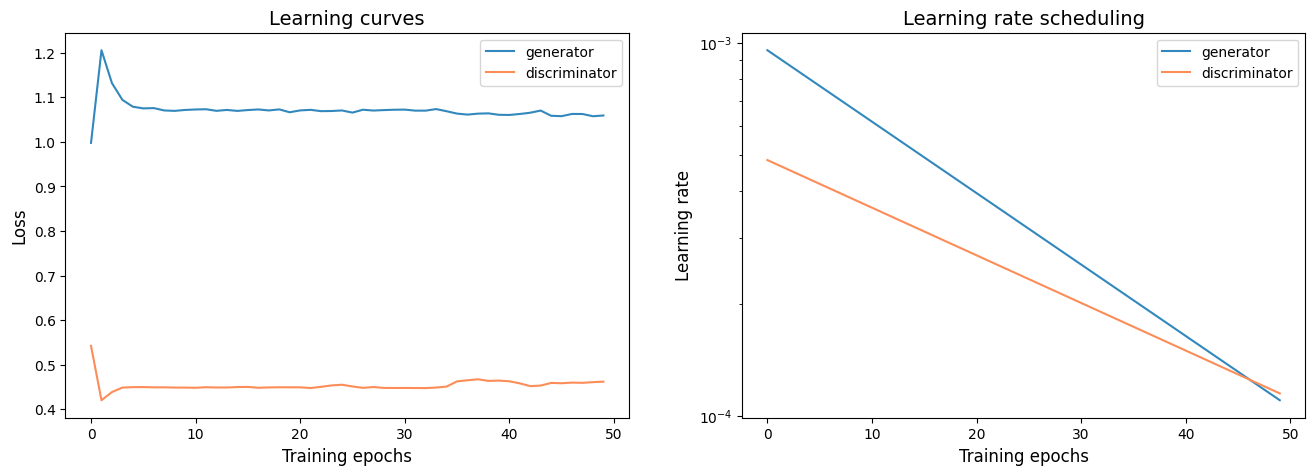

In [71]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.plot(train.history["g_loss"], color="#3288bd", label="generator")
plt.plot(train.history["d_loss"], color="#fc8d59", label="discriminator")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Learning rate scheduling", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Learning rate", fontsize=12)
plt.plot(train.history["g_lr"], color="#3288bd", label="generator")
plt.plot(train.history["d_lr"], color="#fc8d59", label="discriminator")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.show()

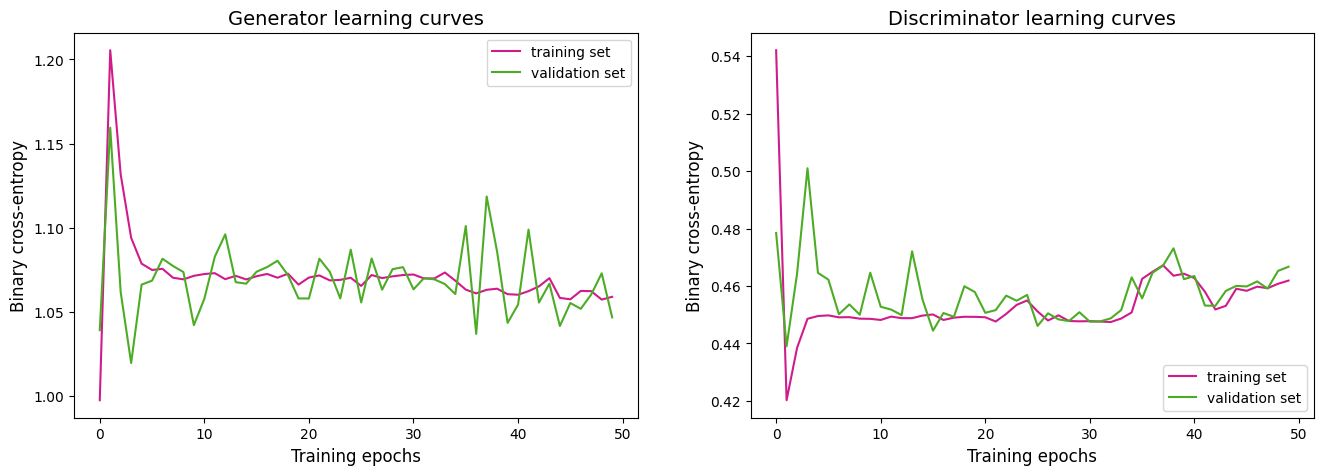

In [72]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Generator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["g_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_g_loss"], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Discriminator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["d_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_d_loss"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

#### Metric curves

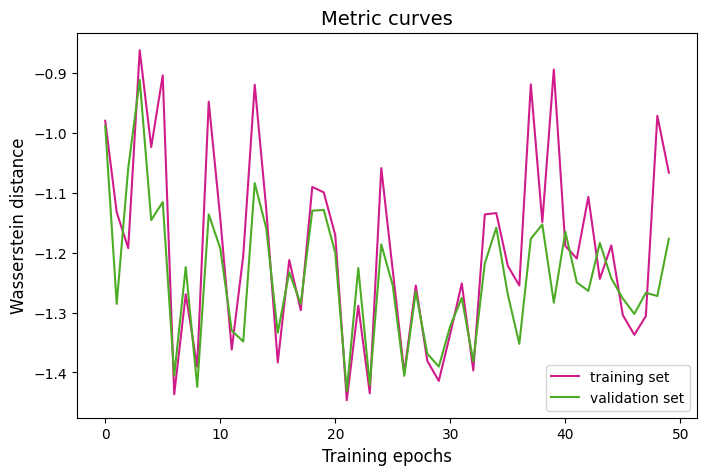

In [73]:
plt.figure(figsize=(8, 5), dpi=100)

plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Wasserstein distance", fontsize=12)
plt.plot(train.history["wass_dist"], color="#d01c8b", label="training set")
plt.plot(train.history["val_wass_dist"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

### Normalizing Flows

TBA

In [74]:
# TBA

### Validation plots

Once trained the WGAN-ALP system, the **generator model** can be used to parameterize the high-level response of the LHCb RICH detectors, namely the RICH differential log-likelihoods for different particle hypotheses. Let's have a look at the achieved performance on the **test set**!

In [75]:
from pidgan.utils.preprocessing import invertColumnTransformer

x_test_prep = x_scaler.transform(x_test[:, :5])  # input pre-processing

int_encoded = label_encoder.transform(x_test[:, 5])
onehot_encoded = onehot_encoder.transform(int_encoded[:, None])
x_test_prep = np.concatenate([x_test_prep, onehot_encoded], axis=1)

In [77]:
# gan_out_test_prep = gan.generate(x_test_prep, seed=None)
# gan_out_test = invertColumnTransformer(y_scaler, gan_out_test_prep)  # output post-processing

In [78]:
gan_out_test_prep = gan.generate(x_test_prep, seed=None)
gan_out_test = y_scaler.inverse_transform(gan_out_test_prep)  # output post-processing

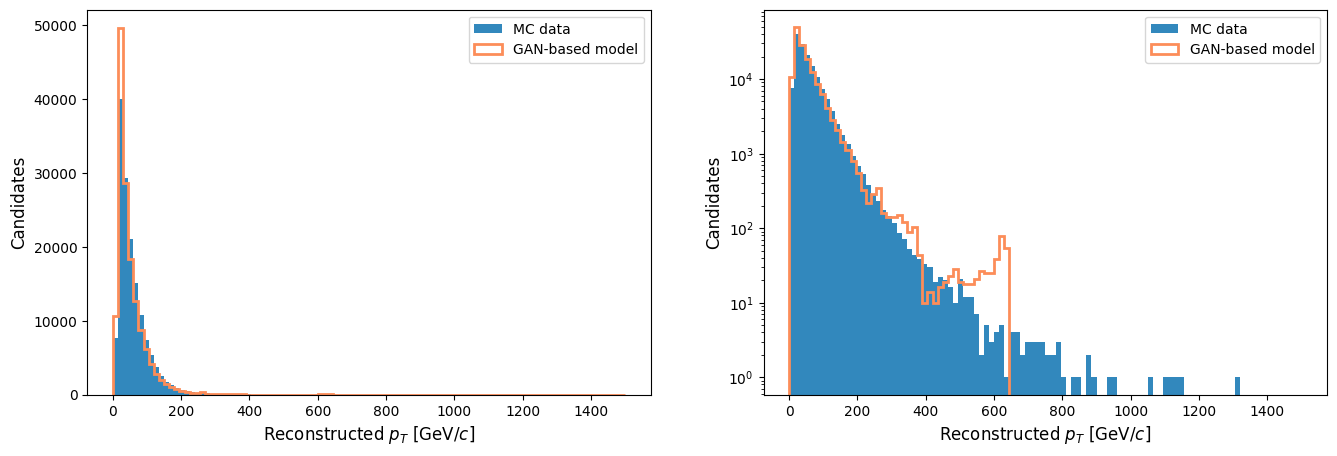

In [79]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(0.0, 1500.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("Reconstructed $p_T$ [GeV/$c$]", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 0], bins=bins, color="#3288bd", label="MC data")
    plt.hist(gan_out_test[:, 0], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN-based model")
    plt.legend(loc="upper right", fontsize=10)
    plt.yscale(scale)

plt.show()

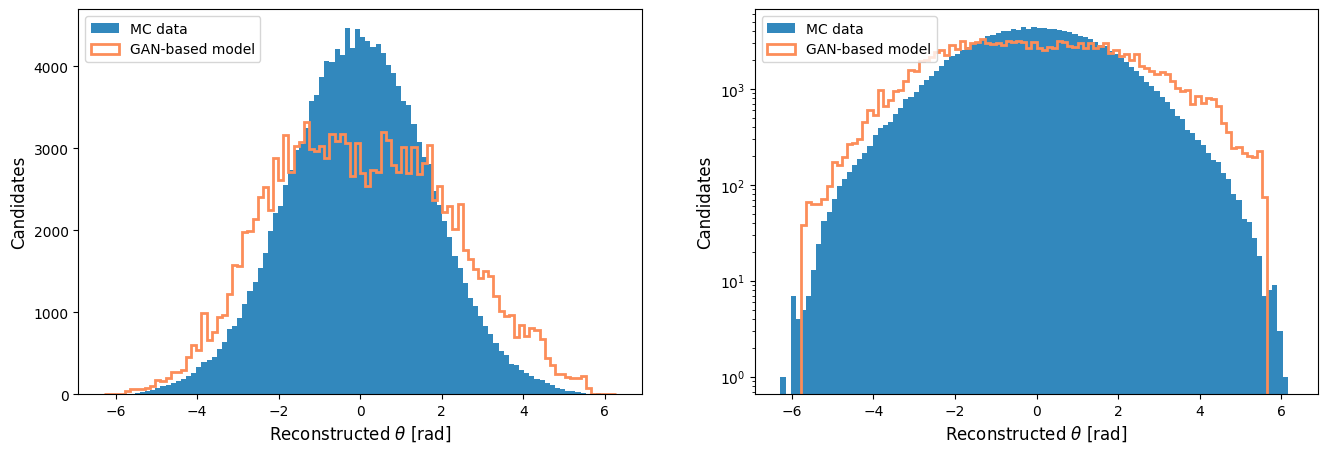

In [80]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-2*np.pi, 2*np.pi, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel(r"Reconstructed $\theta$ [rad]", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 1], bins=bins, color="#3288bd", label="MC data")
    plt.hist(gan_out_test[:, 1], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN-based model")
    plt.legend(loc="upper left", fontsize=10)
    plt.yscale(scale)

plt.show()

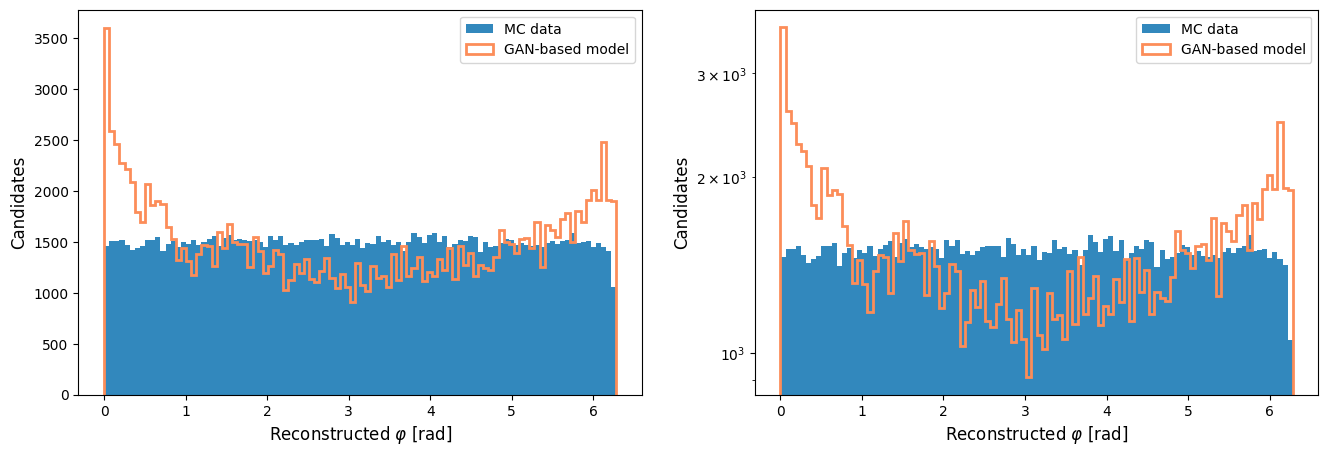

In [81]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(0.0, 2*np.pi, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel(r"Reconstructed $\varphi$ [rad]", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 2], bins=bins, color="#3288bd", label="MC data")
    plt.hist(gan_out_test[:, 2], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN-based model")
    plt.legend(loc="upper right", fontsize=10)
    plt.yscale(scale)

plt.show()

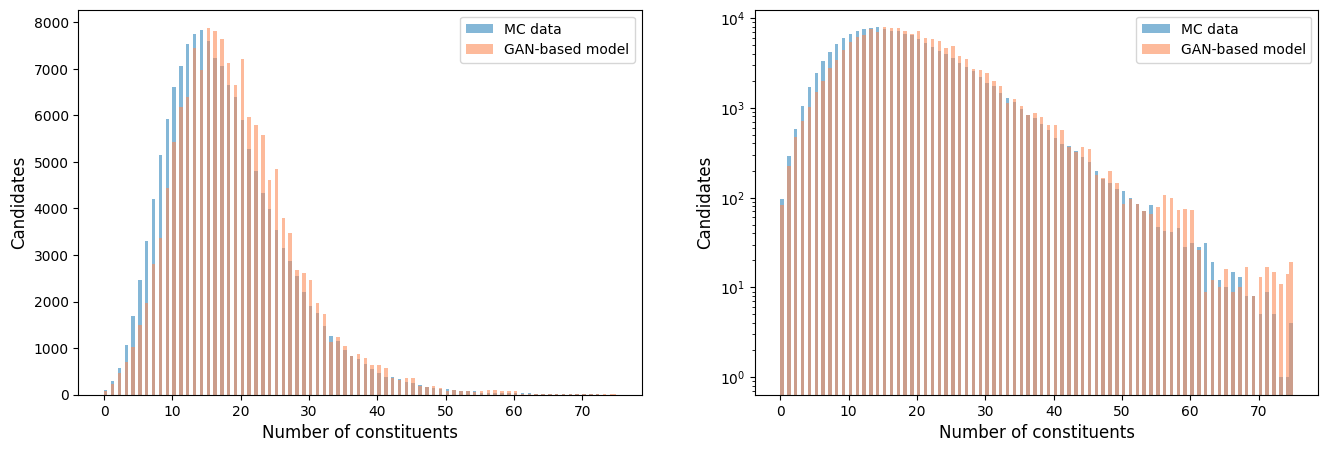

In [88]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(0.0, 75.0, 151)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("Number of constituents", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 3], bins=bins, color="#3288bd", alpha=0.6, label="MC data")
    plt.hist(gan_out_test[:, 3].astype(np.int32), bins=bins, color="#fc8d59", alpha=0.6, label="GAN-based model")
    plt.legend(loc="upper right", fontsize=10)
    plt.yscale(scale)

plt.show()

## References

1. I.J. Goodfellow _et al._, "Generative Adversarial Networks", [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
2. M. Arjovsky, L. Bottou, "Towards Principled Methods for Training Generative Adversarial Networks", [arXiv:1701.04862](https://arxiv.org/abs/1701.04862)
3. M. Arjovsky, S. Chintala, L. Bottou, "Wasserstein GAN", [arXiv:1701.07875](https://arxiv.org/abs/1701.07875)
4. D. Terjék, "Adversarial Lipschitz Regularization", [arXiv:1907.05681](https://arxiv.org/abs/1907.05681)
5. M. Mirza, S. Osindero, "Conditional Generative Adversarial Nets", [arXiv:1411.1784](https://arxiv.org/abs/1411.1784)
6. T. Salimans _et al._, "Improved Techniques for Training GANs", [arXiv:1606.03498](https://arxiv.org/abs/1606.03498)

## Credits
This hands-on is based on the tutorials provided by the [pidgan](https://github.com/mbarbetti/pidgan) package.